# Pembelajaran Mesin: Tugas Besar 1

Kaenova Mahendra Auditama  
IF-43-02  
1301190324  
  
Pada kodingan ini, saya mencoba untuk membuat sebuah model yang akan digunakan untuk membuat cluster pada suatu data. Data yang diberikan merupakan data ketertarikan pelanggan untuk membeli kendaraan baru. Pada akhirnya, saya menggunakan algoritma k-means karena kami diminta untuk membuat model dalam bentuk unsupervised learning
  
  
<sup>\*runs on AI Lab computer</sup>

# Import Library

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle
import random
import math
from sklearn.preprocessing import MinMaxScaler

# Import Data

In [3]:
df_raw = pd.read_csv("https://raw.githubusercontent.com/kaenova/Malin_Tubes1/main/data/raw/kendaraan_train.csv")
df_raw.head()

,id,Jenis_Kelamin,Umur,SIM,Kode_Daerah,Sudah_Asuransi,Umur_Kendaraan,Kendaraan_Rusak,Premi,Kanal_Penjualan,Lama_Berlangganan,Tertarik
0,1,Wanita,30.0,1.0,33.0,1.0,< 1 Tahun,Tidak,28029.0,152.0,97.0,0
1,2,Pria,48.0,1.0,39.0,0.0,> 2 Tahun,Pernah,25800.0,29.0,158.0,0
2,3,NaN,21.0,1.0,46.0,1.0,< 1 Tahun,Tidak,32733.0,160.0,119.0,0
3,4,Wanita,58.0,1.0,48.0,0.0,1-2 Tahun,Tidak,2630.0,124.0,63.0,0
4,5,Pria,50.0,1.0,35.0,0.0,> 2 Tahun,NaN,34857.0,88.0,194.0,0


In [4]:
len(df_raw)

285831

# Data Preprocessing

## Drop data yang ada NaN

In [5]:
df_dropna = df_raw.dropna(how="any")
len(df_dropna)

171068

## Drop data Categorical

In [6]:
df_dropna_dropcategorical = df_dropna.drop(axis=1, columns=["Jenis_Kelamin", "SIM", "Sudah_Asuransi", "Kode_Daerah", "Umur_Kendaraan", "Kendaraan_Rusak", "Kanal_Penjualan"])
df_dropna_dropcategorical.sample(5)

,id,Umur,Premi,Lama_Berlangganan,Tertarik
255536,255537,31.0,40953.0,151.0,0
264866,264867,70.0,27058.0,19.0,0
267151,267152,42.0,28949.0,80.0,0
237150,237151,45.0,33112.0,236.0,0
178144,178145,43.0,28440.0,71.0,0


## Check Outlier

Text(0.5, 1.0, 'Lama Berlangganan')

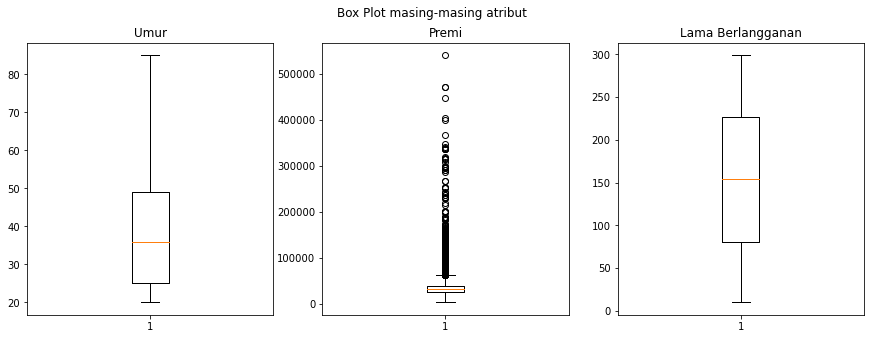

In [7]:
fig, (g1, g2, g3) = plt.subplots(1,3)
fig.suptitle("Box Plot masing-masing atribut")
fig.set_size_inches(15,5)
g1.boxplot(df_dropna_dropcategorical["Umur"])
g1.set_title("Umur")
g2.boxplot(df_dropna_dropcategorical["Premi"])
g2.set_title("Premi")
g3.boxplot(df_dropna_dropcategorical["Lama_Berlangganan"])
g3.set_title("Lama Berlangganan")

## Drop Outlier menggunakan IQR method

In [8]:
describe = df_dropna_dropcategorical.describe()
describe
iqr_premi = float(describe["Premi"].loc["75%"] - describe["Premi"].loc["25%"])
q1_bound = float(describe["Premi"].loc["25%"]) - (iqr_premi * 1.5)
q2_bound = float(describe["Premi"].loc["75%"]) + (iqr_premi * 1.5)
final_df = df_dropna_dropcategorical.copy()
final_df.reset_index(drop=True, inplace=True)
final_df = final_df[(final_df["Premi"] > q1_bound) & (final_df["Premi"] < q2_bound)]
len(final_df)

166396

Text(0.5, 1.0, 'Lama Berlangganan')

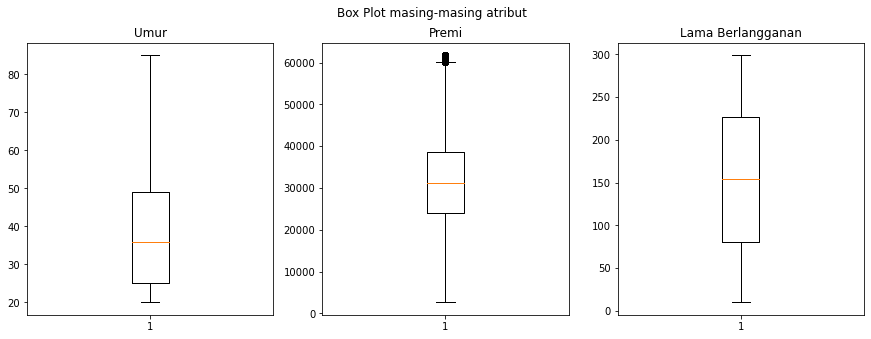

In [9]:
fig, (g1, g2, g3) = plt.subplots(1,3)
fig.suptitle("Box Plot masing-masing atribut")
fig.set_size_inches(15,5)
g1.boxplot(final_df["Umur"])
g1.set_title("Umur")
g2.boxplot(final_df["Premi"])
g2.set_title("Premi")
g3.boxplot(final_df["Lama_Berlangganan"])
g3.set_title("Lama Berlangganan")

# Modelling

In [18]:
class KMeans:
  training_arr = None
  point = None
  inertia = None
  
  def __init__(self, df: pd.DataFrame):
    '''
    Kelas ini digunakan untuk menyiapkan dataframe yang akan ditraining.
    Pastikan kolom bernama id atau sejenis sudah di drop tidak termasuk ke dalam dataframe.
    '''
    print("K-Means akan ditentukan oleh atribut-atribut di bawah ini:")
    print("[", end="")
    for i in range(len(df.columns)):
      print(df.columns[i] + " ", end="")
    print("]", end="\n")
    self.training_arr = df.to_numpy()
    
  def fit_predict(self, k_num:int = 3, max_step:int = 500, conv_threshold: float = 1e-5) -> np.array:
    '''
    Membuat model KMeans dengan K tertentu. Akan mengkembalikan hasil prediksi cluster.
    Poin kluster akan disimpan pada variable point
    '''
    # Setting up cluster arry for every record
    cluster = np.zeros(len(self.training_arr))
    
    # normalize data
    data = self.__normalize_data__(self.training_arr)
    
    # Initialize centroid using KMeans++  
    point = self.__initialize_centroids__(data, k_num)
        
    # Setup convergence and counter
    convergence = False
    step = 0 
        
    while not convergence and (step < max_step):
      initial_point = point
      distance = self.__calculate_distance__(data, point)
      cluster = self.__clustering__(distance)
      new_point = self.__point_nomralization__(data, point, cluster)
      convergence = self.__convergence_check__(initial_point, new_point, conv_threshold)
      
      if convergence:
        print("It's convergence!")
      else:
        point = new_point
        step += 1
        print("STEP:", step)
      
    
    self.inertia = self.__calculate_inertia__(data, cluster, point)
    self.point = self.__denormalize_point__(point, self.training_arr)
    return cluster
    
  # Made by Kaenova Mahendra Auditama | 1301190324 | IF-43-02
  def get_cluster_centroid(self) -> np.array:
    '''
    Fungsi ini digunakan untuk mengambil point
    '''
    if type(self.point) == "NoneType":
      print("Nothing returned, point not initialize. Try using fit_predict first.")
      return
    return self.point
  
  
  def __initialize_centroids__(self, data:np.array, k:np.array) -> np.array:
    '''
    Fungsi ini digunakan untuk menginisialisasikan centroid. Menggunakan algoritma k-means++
    referensi membantu: https://www.youtube.com/watch?v=HatwtJSsj5Q
    '''
    centroids = []
    centroids.append( data[random.randrange(0, len(data))] )
    
    for i in range(1, k):
      min_dist = []
      for data_point in data:
        distance_data_point = []
        for point in centroids:
          distance_data_point.append(np.linalg.norm(data_point - point))
        min_dist.append(min(distance_data_point))
      
      probcum  = sum(min_dist)
      prob_point = [value / probcum for value in min_dist]
      
      centroids.append(data[np.argmax(prob_point)])
    
    return np.array(centroids)
  
  
  def __clustering__(self, distance: np.array) -> np.array:
    '''
    Fungsi ini akan mengembalikan hasil clustering berdasarkan distance
    '''
    cluster = np.zeros(len(distance))
    for i in range(len(cluster)):
      cluster[i] = np.argmin(distance[i])
    return cluster
  # Made by Kaenova Mahendra Auditama | 1301190324 | IF-43-02
  def __calculate_distance__(self, data:np.array, point: np.array) -> np.array:
    '''
    Fungsi ini akan menghitung setiap titik dengan point dan mengkembalikan jarak dari titik ke point
    '''
    distance = np.zeros((len(data), len(point)))
    
    for i in range(len(data)):
      current_record = data[i]
      for j in range(len(point)):
        current_point = point[j]
        # numpy eucledience distance
        distance[i][j] = np.linalg.norm(current_point - current_record)
    
    return distance
  
  def __point_nomralization__(self, data:np.array, point:np.array, cluster:np.array) -> (np.array, np.array):
    '''
    Fungsi ini digunakan untuk clustering dan normalisasi point
    '''
    new_point = np.zeros((len(point), len(point[0])))
    counter_array = np.zeros(len(point))
    for i in range(len(cluster)):
      new_point[int(cluster[i])] = new_point[int(cluster[i])] + data[i]
      counter_array[int(cluster[i])] += 1
      
    unique_on_cluster = np.unique(cluster)
    for i in range(len(point)):
      # nan handling
      if i not in unique_on_cluster:
        new_point[i] = point[i]
      else:
        new_point[i] = np.true_divide(new_point[i], counter_array[i])
      
    return new_point
  # Made by Kaenova Mahendra Auditama | 1301190324 | IF-43-02
  def __convergence_check__(self, points1: np.array, points2:np.array, threshold: float) -> bool:
    '''
    Fungsi ini untuk mengecek convergence berdasarkan threshold yang dibuat.
    titik cluster pertama akan dibandingkan dengan titik cluster kedua.
    note: maybe i should use euclediance distance insted of menghitung satu-satu
    '''
    local_convergence = False
    normalize_threshold_positive, normalize_threshold_negative  = 1 + threshold, 1 - threshold
    points_counter = 0
    center = np.zeros(len(points1[0]))
    for i in range(len(points1)):
      current_first_point, current_second_point = points1[i], points2[i]
      distance_first_point, distance_second_point = np.linalg.norm(current_first_point - center), np.linalg.norm(current_second_point - center)
      distance_threshold_positive = distance_first_point * normalize_threshold_positive
      distance_threshold_negative = distance_first_point * normalize_threshold_negative
      if distance_threshold_positive > distance_second_point and distance_threshold_negative < distance_second_point:
        points_counter += 1
    
    if points_counter == len(points1):
      local_convergence = True
    
    return local_convergence
  
  def __calculate_inertia__(self, data:np.array, cluster:np.array, points:np.array) -> np.array:
    '''
    K-Means: Inertia
    Inertia measures how well a dataset was clustered by K-Means. It is calculated by measuring the distance between each data point and its centroid, squaring this distance, and summing these squares across one cluster.
    ref: https://www.codecademy.com/learn/machine-learning/modules/dspath-clustering/cheatsheet
    '''
    inertia = 0
    for i in range(len(data)):
      inertia += math.sqrt(np.linalg.norm(data[i] - points[int(cluster[i])]))
      
    return inertia
  
  def __normalize_data__(self, data:np.array) -> np.array:
    '''
    Fungsi ini digunakan untuk menormalisasikan data dengan menggunakan min-max scaling. Sehingga data berjenis dan bersatuan apapun data diproses dengan baik.
    '''
    data = data.copy()
    for i in range(len(data[0])):
      col_arr = data[:,i]
      minmax = MinMaxScaler()
      normalize = minmax.fit_transform(col_arr.reshape(-1,1)).reshape(1,-1)
      data[:, i] = normalize[0]
      
    return data
  
  def __denormalize_point__(self, data:np.array, original_data:np.array) -> np.array:
    '''
    Fungsi ini digunakan untuk mendenormalisasikan point-point yang sudah dihitung menggunakan data yang ternormalisasi
    '''
    for i in range(len(data[0])):
      col_arr = data[:,i]
      col_arr_ori = original_data[:, i]
      
      minimums = min(col_arr_ori)
      maximums = max(col_arr_ori)
      for j in range(len(col_arr)):
        col_arr[j] = ((col_arr[j]*(maximums - minimums)) + minimums)
      data[:, i] = col_arr
    return data

# Eksperimen

In [19]:
df_training = final_df.copy()
df_training.set_index("id", inplace=True)
df_labels = df_training["Tertarik"]
df_training.drop(columns="Tertarik", axis=1, inplace=True)

In [20]:
df_training.head()

,Umur,Premi,Lama_Berlangganan
id,,,
1,30.0,28029.0,97.0
2,48.0,25800.0,158.0
4,58.0,2630.0,63.0
6,21.0,22735.0,171.0
9,20.0,30786.0,31.0


In [21]:
len(df_training)

166396

## Mencoba 3 Atribut yang digunakan

In [22]:
MAX_K = 15

import pandas as pd

data3_k_run_history = {
  "data" : "3 Data", 
  "k_runs" : {}
}

for i in range(1, MAX_K+1):
  print("==== K:", i, "====" )
  run_data = {
    "points" : None,
    "cluster" : None,
    "inertia" : None
  }
  
  model = KMeans(df_training)
  run_data["cluster"] = model.fit_predict(k_num=i, conv_threshold=1e-15)
  run_data["inertia"] = model.inertia
  run_data["points"] = model.point
  data3_k_run_history["k_runs"][i] = run_data

==== K: 1 ====
K-Means akan ditentukan oleh atribut-atribut di bawah ini:
[Umur Premi Lama_Berlangganan ]
STEP: 1
It's convergence!
==== K: 2 ====
K-Means akan ditentukan oleh atribut-atribut di bawah ini:
[Umur Premi Lama_Berlangganan ]
STEP: 1
STEP: 2
STEP: 3
STEP: 4
STEP: 5
STEP: 6
STEP: 7
STEP: 8
STEP: 9
STEP: 10
STEP: 11
STEP: 12
STEP: 13
It's convergence!
==== K: 3 ====
K-Means akan ditentukan oleh atribut-atribut di bawah ini:
[Umur Premi Lama_Berlangganan ]
STEP: 1
STEP: 2
STEP: 3
STEP: 4
STEP: 5
STEP: 6
STEP: 7
STEP: 8
STEP: 9
STEP: 10
STEP: 11
STEP: 12
STEP: 13
STEP: 14
STEP: 15
It's convergence!
==== K: 4 ====
K-Means akan ditentukan oleh atribut-atribut di bawah ini:
[Umur Premi Lama_Berlangganan ]
STEP: 1
STEP: 2
STEP: 3
STEP: 4
STEP: 5
STEP: 6
STEP: 7
STEP: 8
STEP: 9
STEP: 10
STEP: 11
STEP: 12
STEP: 13
STEP: 14
STEP: 15
STEP: 16
STEP: 17
STEP: 18
STEP: 19
STEP: 20
STEP: 21
STEP: 22
STEP: 23
STEP: 24
STEP: 25
STEP: 26
STEP: 27
STEP: 28
STEP: 29
STEP: 30
STEP: 31
STEP: 32
S

STEP: 70
STEP: 71
STEP: 72
STEP: 73
STEP: 74
STEP: 75
STEP: 76
STEP: 77
STEP: 78
STEP: 79
STEP: 80
STEP: 81
STEP: 82
STEP: 83
STEP: 84
STEP: 85
STEP: 86
STEP: 87
STEP: 88
STEP: 89
STEP: 90
STEP: 91
STEP: 92
STEP: 93
STEP: 94
STEP: 95
STEP: 96
STEP: 97
STEP: 98
STEP: 99
STEP: 100
STEP: 101
STEP: 102
STEP: 103
STEP: 104
STEP: 105
STEP: 106
STEP: 107
STEP: 108
STEP: 109
STEP: 110
STEP: 111
STEP: 112
STEP: 113
STEP: 114
STEP: 115
STEP: 116
STEP: 117
STEP: 118
STEP: 119
STEP: 120
STEP: 121
STEP: 122
STEP: 123
STEP: 124
STEP: 125
STEP: 126
STEP: 127
STEP: 128
STEP: 129
STEP: 130
STEP: 131
STEP: 132
STEP: 133
STEP: 134
It's convergence!


In [23]:
FILE_NAME = "3data_runs_15k.pckl"
f = open('./saved_vars/'+FILE_NAME, 'wb')
pickle.dump(data3_k_run_history, f)
f.close()

## Mencoba 2 Atribut

### Atribut Umur dan Premi

In [24]:
MAX_K = 15

import pandas as pd

data2_umur_premi_k_run_history = {
  "data" : "2 Data Umur dan Premi", 
  "k_runs" : {}
}

for i in range(1, MAX_K+1):
  print("==== K:", i, "====" )
  run_data = {
    "points" : None,
    "cluster" : None,
    "inertia" : None
  }
  
  model = KMeans(df_training.drop(columns="Lama_Berlangganan", axis=1))
  run_data["cluster"] = model.fit_predict(k_num=i, conv_threshold=1e-15)
  run_data["inertia"] = model.inertia
  run_data["points"] = model.point
  data2_umur_premi_k_run_history["k_runs"][i] = run_data

==== K: 1 ====
K-Means akan ditentukan oleh atribut-atribut di bawah ini:
[Umur Premi ]
STEP: 1
It's convergence!
==== K: 2 ====
K-Means akan ditentukan oleh atribut-atribut di bawah ini:
[Umur Premi ]
STEP: 1
STEP: 2
STEP: 3
STEP: 4
STEP: 5
STEP: 6
STEP: 7
STEP: 8
STEP: 9
STEP: 10
STEP: 11
STEP: 12
STEP: 13
STEP: 14
STEP: 15
STEP: 16
It's convergence!
==== K: 3 ====
K-Means akan ditentukan oleh atribut-atribut di bawah ini:
[Umur Premi ]
STEP: 1
STEP: 2
STEP: 3
STEP: 4
STEP: 5
STEP: 6
STEP: 7
STEP: 8
STEP: 9
STEP: 10
STEP: 11
STEP: 12
STEP: 13
STEP: 14
It's convergence!
==== K: 4 ====
K-Means akan ditentukan oleh atribut-atribut di bawah ini:
[Umur Premi ]
STEP: 1
STEP: 2
STEP: 3
STEP: 4
STEP: 5
STEP: 6
STEP: 7
STEP: 8
STEP: 9
STEP: 10
STEP: 11
STEP: 12
STEP: 13
STEP: 14
STEP: 15
It's convergence!
==== K: 5 ====
K-Means akan ditentukan oleh atribut-atribut di bawah ini:
[Umur Premi ]
STEP: 1
STEP: 2
STEP: 3
STEP: 4
STEP: 5
STEP: 6
STEP: 7
STEP: 8
STEP: 9
STEP: 10
STEP: 11
STEP: 12
STE

STEP: 56
STEP: 57
STEP: 58
STEP: 59
STEP: 60
STEP: 61
STEP: 62
STEP: 63
STEP: 64
STEP: 65
STEP: 66
STEP: 67
STEP: 68
STEP: 69
STEP: 70
STEP: 71
STEP: 72
STEP: 73
STEP: 74
STEP: 75
STEP: 76
It's convergence!
==== K: 14 ====
K-Means akan ditentukan oleh atribut-atribut di bawah ini:
[Umur Premi ]
STEP: 1
STEP: 2
STEP: 3
STEP: 4
STEP: 5
STEP: 6
STEP: 7
STEP: 8
STEP: 9
STEP: 10
STEP: 11
STEP: 12
STEP: 13
STEP: 14
STEP: 15
STEP: 16
STEP: 17
STEP: 18
STEP: 19
STEP: 20
STEP: 21
STEP: 22
STEP: 23
STEP: 24
STEP: 25
STEP: 26
STEP: 27
STEP: 28
STEP: 29
STEP: 30
STEP: 31
STEP: 32
STEP: 33
STEP: 34
STEP: 35
STEP: 36
STEP: 37
STEP: 38
STEP: 39
STEP: 40
STEP: 41
STEP: 42
STEP: 43
STEP: 44
STEP: 45
STEP: 46
STEP: 47
STEP: 48
STEP: 49
STEP: 50
STEP: 51
STEP: 52
STEP: 53
STEP: 54
STEP: 55
STEP: 56
STEP: 57
STEP: 58
STEP: 59
It's convergence!
==== K: 15 ====
K-Means akan ditentukan oleh atribut-atribut di bawah ini:
[Umur Premi ]
STEP: 1
STEP: 2
STEP: 3
STEP: 4
STEP: 5
STEP: 6
STEP: 7
STEP: 8
STEP: 9
STE

In [25]:
FILE_NAME = "2data_umur_premi_runs_15k.pckl"
f = open('./saved_vars/'+FILE_NAME, 'wb')
pickle.dump(data2_umur_premi_k_run_history, f)
f.close()

### Atribut Umur dan Lama_Berlangganan

In [26]:
MAX_K = 15

import pandas as pd

data2_umur_berlangganan_k_run_history = {
  "data" : "2 Data Umur dan Lama Berlangganan", 
  "k_runs" : {}
}

for i in range(1, MAX_K+1):
  print("==== K:", i, "====" )
  run_data = {
    "points" : None,
    "cluster" : None,
    "inertia" : None
  }
  
  model = KMeans(df_training.drop(columns="Premi", axis=1))
  run_data["cluster"] = model.fit_predict(k_num=i, conv_threshold=1e-15)
  run_data["inertia"] = model.inertia
  run_data["points"] = model.point
  data2_umur_berlangganan_k_run_history["k_runs"][i] = run_data

==== K: 1 ====
K-Means akan ditentukan oleh atribut-atribut di bawah ini:
[Umur Lama_Berlangganan ]
STEP: 1
It's convergence!
==== K: 2 ====
K-Means akan ditentukan oleh atribut-atribut di bawah ini:
[Umur Lama_Berlangganan ]
STEP: 1
STEP: 2
STEP: 3
STEP: 4
STEP: 5
STEP: 6
STEP: 7
STEP: 8
STEP: 9
STEP: 10
It's convergence!
==== K: 3 ====
K-Means akan ditentukan oleh atribut-atribut di bawah ini:
[Umur Lama_Berlangganan ]
STEP: 1
STEP: 2
STEP: 3
STEP: 4
STEP: 5
STEP: 6
STEP: 7
STEP: 8
STEP: 9
STEP: 10
STEP: 11
STEP: 12
STEP: 13
STEP: 14
STEP: 15
STEP: 16
STEP: 17
STEP: 18
STEP: 19
STEP: 20
STEP: 21
STEP: 22
STEP: 23
STEP: 24
STEP: 25
STEP: 26
STEP: 27
STEP: 28
STEP: 29
STEP: 30
STEP: 31
STEP: 32
STEP: 33
STEP: 34
STEP: 35
STEP: 36
STEP: 37
STEP: 38
STEP: 39
STEP: 40
STEP: 41
STEP: 42
STEP: 43
STEP: 44
STEP: 45
STEP: 46
STEP: 47
STEP: 48
STEP: 49
STEP: 50
STEP: 51
It's convergence!
==== K: 4 ====
K-Means akan ditentukan oleh atribut-atribut di bawah ini:
[Umur Lama_Berlangganan ]
STEP: 1

STEP: 114
STEP: 115
STEP: 116
STEP: 117
STEP: 118
STEP: 119
STEP: 120
STEP: 121
It's convergence!


In [27]:
FILE_NAME = "2data_umur_berlangganan_runs_15k.pckl"
f = open('./saved_vars/'+FILE_NAME, 'wb')
pickle.dump(data2_umur_berlangganan_k_run_history, f)
f.close()

### Atribut Premi dan Lama Berlangganan

In [28]:
MAX_K = 15

import pandas as pd

data2_premi_berlangganan_k_run_history = {
  "data" : "2 Data Premi dan Lama Berlangganan", 
  "k_runs" : {}
}

for i in range(1, MAX_K+1):
  print("==== K:", i, "====" )
  run_data = {
    "points" : None,
    "cluster" : None,
    "inertia" : None
  }
  
  model = KMeans(df_training.drop(columns="Umur", axis=1))
  run_data["cluster"] = model.fit_predict(k_num=i, conv_threshold=1e-15)
  run_data["inertia"] = model.inertia
  run_data["points"] = model.point
  data2_premi_berlangganan_k_run_history["k_runs"][i] = run_data

==== K: 1 ====
K-Means akan ditentukan oleh atribut-atribut di bawah ini:
[Premi Lama_Berlangganan ]
STEP: 1
It's convergence!
==== K: 2 ====
K-Means akan ditentukan oleh atribut-atribut di bawah ini:
[Premi Lama_Berlangganan ]
STEP: 1
STEP: 2
STEP: 3
STEP: 4
STEP: 5
STEP: 6
STEP: 7
STEP: 8
STEP: 9
STEP: 10
STEP: 11
STEP: 12
STEP: 13
It's convergence!
==== K: 3 ====
K-Means akan ditentukan oleh atribut-atribut di bawah ini:
[Premi Lama_Berlangganan ]
STEP: 1
STEP: 2
STEP: 3
STEP: 4
STEP: 5
STEP: 6
STEP: 7
STEP: 8
STEP: 9
It's convergence!
==== K: 4 ====
K-Means akan ditentukan oleh atribut-atribut di bawah ini:
[Premi Lama_Berlangganan ]
STEP: 1
STEP: 2
STEP: 3
STEP: 4
STEP: 5
STEP: 6
STEP: 7
STEP: 8
STEP: 9
STEP: 10
STEP: 11
STEP: 12
STEP: 13
STEP: 14
STEP: 15
STEP: 16
STEP: 17
STEP: 18
STEP: 19
It's convergence!
==== K: 5 ====
K-Means akan ditentukan oleh atribut-atribut di bawah ini:
[Premi Lama_Berlangganan ]
STEP: 1
STEP: 2
STEP: 3
STEP: 4
STEP: 5
STEP: 6
STEP: 7
STEP: 8
STEP: 9
S

STEP: 76
It's convergence!
==== K: 15 ====
K-Means akan ditentukan oleh atribut-atribut di bawah ini:
[Premi Lama_Berlangganan ]
STEP: 1
STEP: 2
STEP: 3
STEP: 4
STEP: 5
STEP: 6
STEP: 7
STEP: 8
STEP: 9
STEP: 10
STEP: 11
STEP: 12
STEP: 13
STEP: 14
STEP: 15
STEP: 16
STEP: 17
STEP: 18
STEP: 19
STEP: 20
STEP: 21
STEP: 22
STEP: 23
STEP: 24
STEP: 25
STEP: 26
STEP: 27
STEP: 28
STEP: 29
STEP: 30
STEP: 31
STEP: 32
STEP: 33
STEP: 34
STEP: 35
STEP: 36
STEP: 37
STEP: 38
STEP: 39
STEP: 40
STEP: 41
STEP: 42
STEP: 43
STEP: 44
STEP: 45
STEP: 46
STEP: 47
STEP: 48
STEP: 49
STEP: 50
STEP: 51
STEP: 52
STEP: 53
STEP: 54
STEP: 55
STEP: 56
STEP: 57
STEP: 58
STEP: 59
STEP: 60
STEP: 61
STEP: 62
STEP: 63
STEP: 64
STEP: 65
STEP: 66
STEP: 67
STEP: 68
STEP: 69
STEP: 70
STEP: 71
STEP: 72
STEP: 73
STEP: 74
STEP: 75
STEP: 76
STEP: 77
STEP: 78
STEP: 79
STEP: 80
STEP: 81
STEP: 82
STEP: 83
STEP: 84
STEP: 85
STEP: 86
STEP: 87
STEP: 88
STEP: 89
STEP: 90
STEP: 91
STEP: 92
STEP: 93
STEP: 94
STEP: 95
STEP: 96
STEP: 97
STEP: 9

In [29]:
FILE_NAME = "2data_premi_berlangganan_runs_15k.pckl"
f = open('./saved_vars/'+FILE_NAME, 'wb')
pickle.dump(data2_umur_berlangganan_k_run_history, f)
f.close()